In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('notebook', font_scale= 1.2)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler

In [2]:
data = pd.read_csv('stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


First thing I notice is the id column and NaN value in the BMI column. I don't think ID will be useful in our analysis, so I will just drop it. 

In [3]:
data.drop('id', axis= 1, inplace= True)

In [4]:
data.shape

(5110, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


We can see that Hypertension, heart disease and stroke have an integer data type but we know that they are categorical variables. So I will convert them to object datatype.

In [6]:
data[['hypertension', 'heart_disease', 'stroke']] = data[['hypertension', 'heart_disease', 'stroke']].astype(str)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   object 
 3   heart_disease      5110 non-null   object 
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   object 
dtypes: float64(3), object(8)
memory usage: 439.3+ KB


In [8]:
data.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


It seems like we have some outliers in avg_glucose_level and bmi column. So lets construct a boxplot of our numerical variable to check for outliers

## **Exploratory Data Analysis**

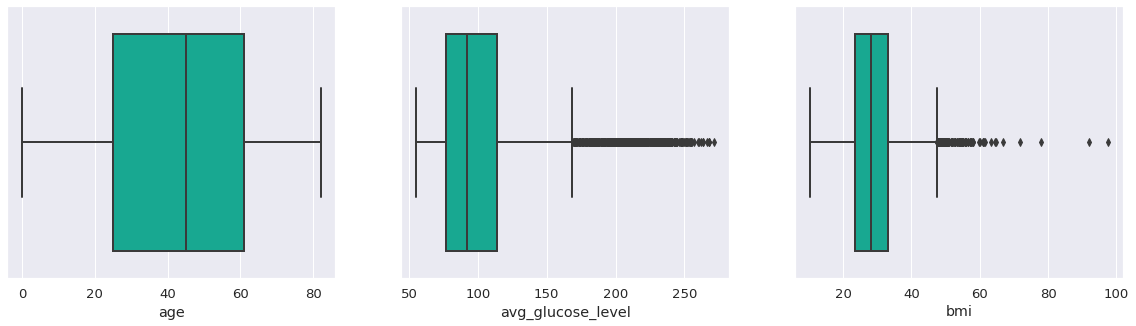

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
sns.boxplot(x = data['age'], ax= ax[0], color= '#00C0A1', linewidth= 2)
sns.boxplot(x = data['avg_glucose_level'], ax= ax[1], color= '#00C0A1', linewidth= 2)
sns.boxplot(x = data['bmi'], ax= ax[2], color= '#00C0A1', linewidth= 2)
plt.show()

We clearly have a lot of outliers in avg_glucose_level and BMI column. Let us also check how their distribution changes according to our target variable before we deal with these outliers

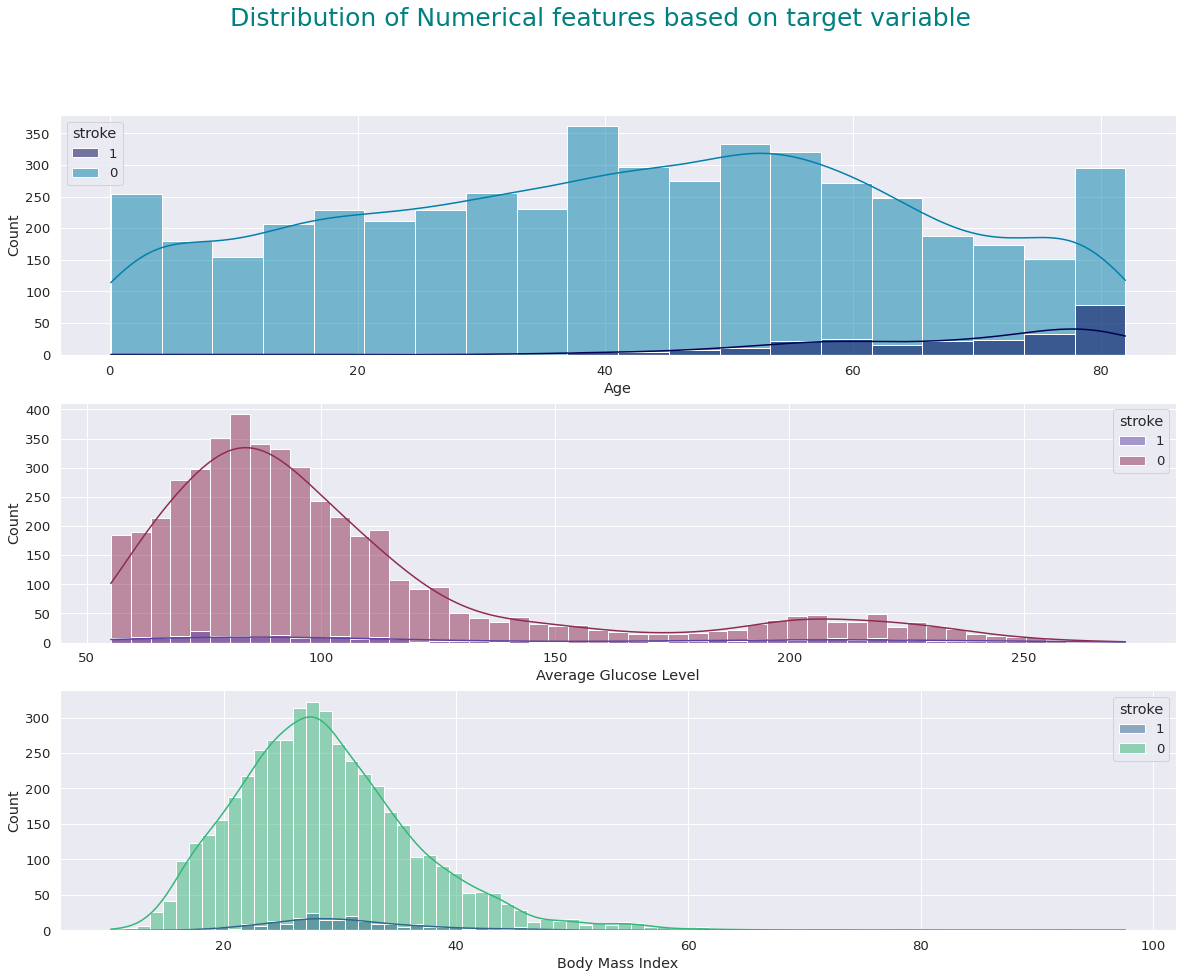

In [10]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))
plt.suptitle('Distribution of Numerical features based on target variable', fontsize = 25, color = 'teal')
sns.histplot(x = data['age'], hue= data['stroke'], kde= True, ax= ax[0], palette = 'ocean')
ax[0].set(xlabel = 'Age')
sns.histplot(x = data['avg_glucose_level'], hue= data['stroke'], kde= True, ax= ax[1], palette = 'twilight')
ax[1].set(xlabel = 'Average Glucose Level')
sns.histplot(x = data['bmi'], hue= data['stroke'], kde= True, ax= ax[2], palette = 'viridis')
ax[2].set(xlabel = 'Body Mass Index')
plt.show()

We clearly spot a pattern in the distribution of `Age`. Older people have a much higher chance of getting a stroke as compared to younger individuals.

Let us deal with outliers in the `avg_glucose_level` and `bmi` column. I will apply log transformation to these columns

In [11]:
for col in ['avg_glucose_level', 'bmi']:
    data[col] = np.log(data[col])

In [12]:
data.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,4.592465,3.328423
std,22.612647,0.361985,0.265064
min,0.080000,4.009513,2.332144
25%,25.000000,4.346982,3.157000
50%,45.000000,4.520538,3.335770
75%,61.000000,4.736988,3.499533
max,82.000000,5.604846,4.580877


Now lets try to visualise the unique values we have in our categorical features.

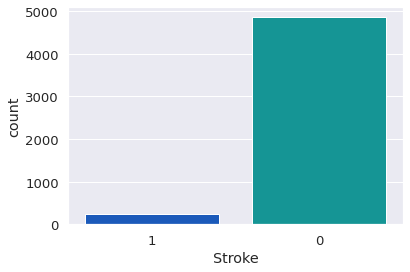

In [13]:
sns.countplot(x = data['stroke'], palette= 'winter')
plt.xlabel('Stroke');

The number of people who actually had a stroke are very less in our dataset. We will have to keep that in mind when we split our dataset

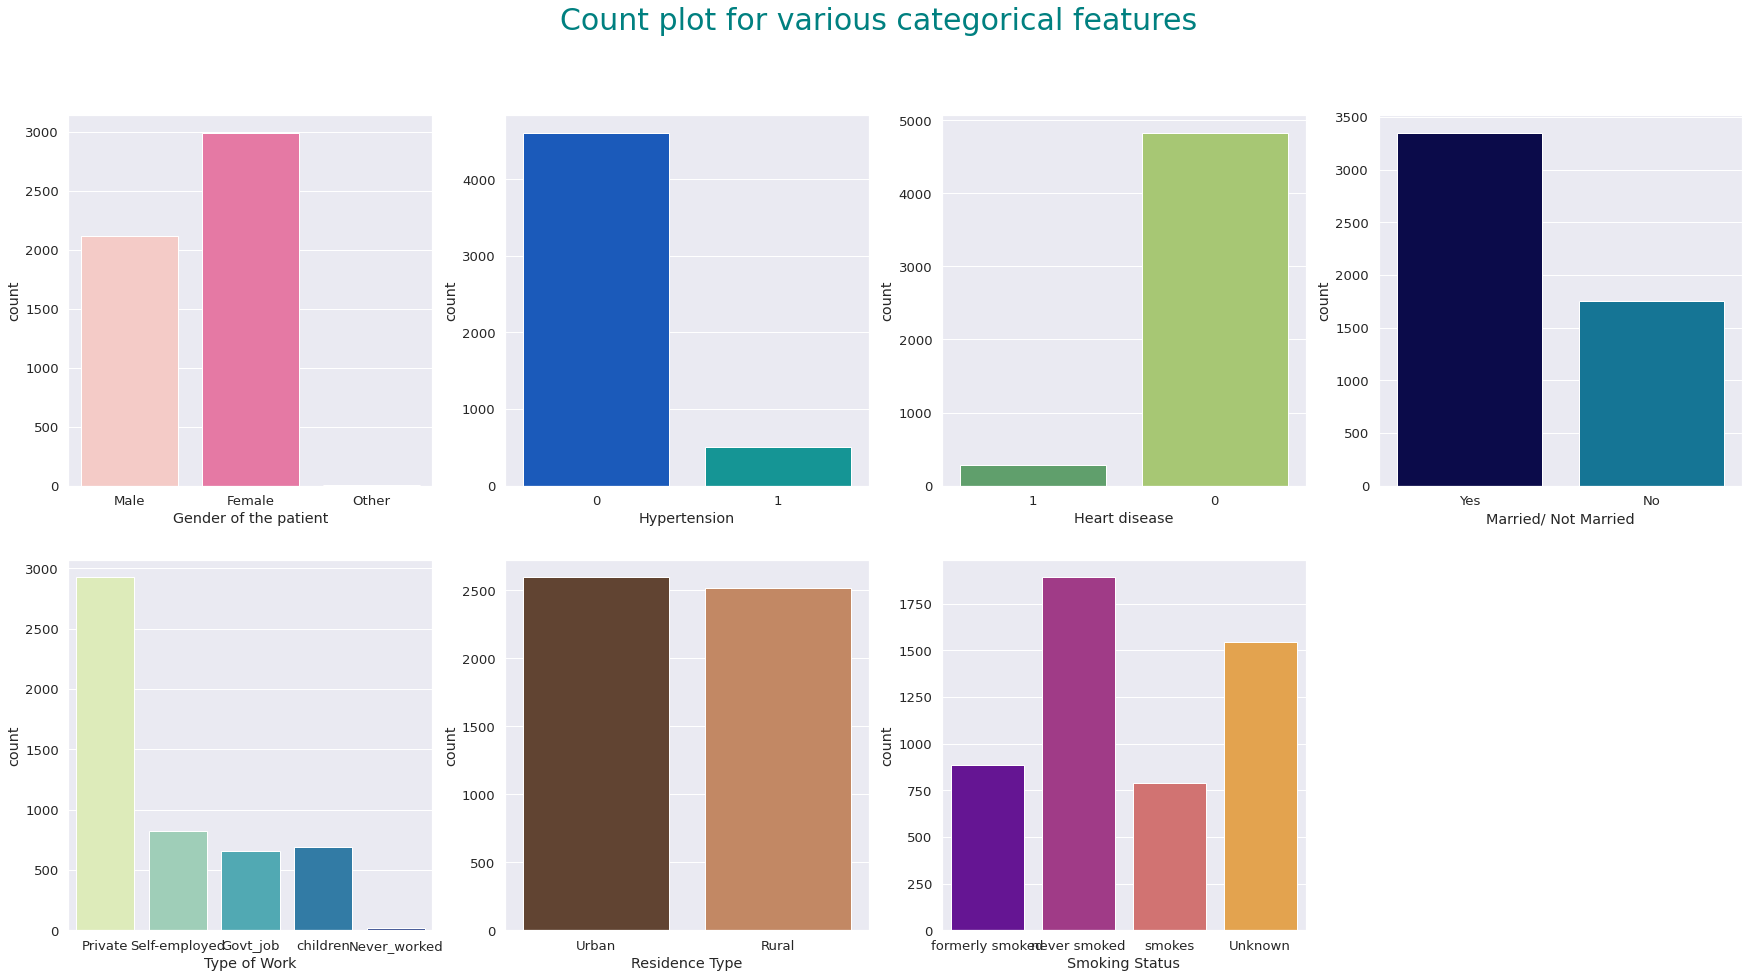

In [14]:
fig, ax = plt.subplots(2, 4, figsize = (30, 15))
ax[1, 3].axis('off')

plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

ax1 = sns.countplot(x ='gender', data= data, ax= ax[0, 0], palette= 'RdPu')
ax1.set(xlabel = 'Gender of the patient')

ax2 = sns.countplot(x ='hypertension', data= data, ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'Hypertension')

ax3 = sns.countplot(x ='heart_disease', data= data, ax= ax[0, 2], palette= 'summer')
ax3.set(xlabel = 'Heart disease')

ax4 = sns.countplot(x ='ever_married', data= data, ax= ax[0, 3], palette= 'ocean')
ax4.set(xlabel = 'Married/ Not Married')

ax5 = sns.countplot(x ='work_type', data= data, ax= ax[1, 0], palette= 'YlGnBu')
ax5.set(xlabel = 'Type of Work')

ax6 = sns.countplot(x ='Residence_type', data= data, ax= ax[1, 1], palette= 'copper')
ax6.set(xlabel = 'Residence Type')

ax7 = sns.countplot(x ='smoking_status', data= data, ax= ax[1, 2], palette= 'plasma')
ax7.set(xlabel = 'Smoking Status')

plt.show()

One thing I did notice is we have a **Other** category in Gender column. I am just going to drop it for simplicity sake.

In [15]:
data['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [16]:
data.drop(data[data['gender'] == 'Other'].index, inplace= True)

Now let us try and visualise our categorical features based on our target variable

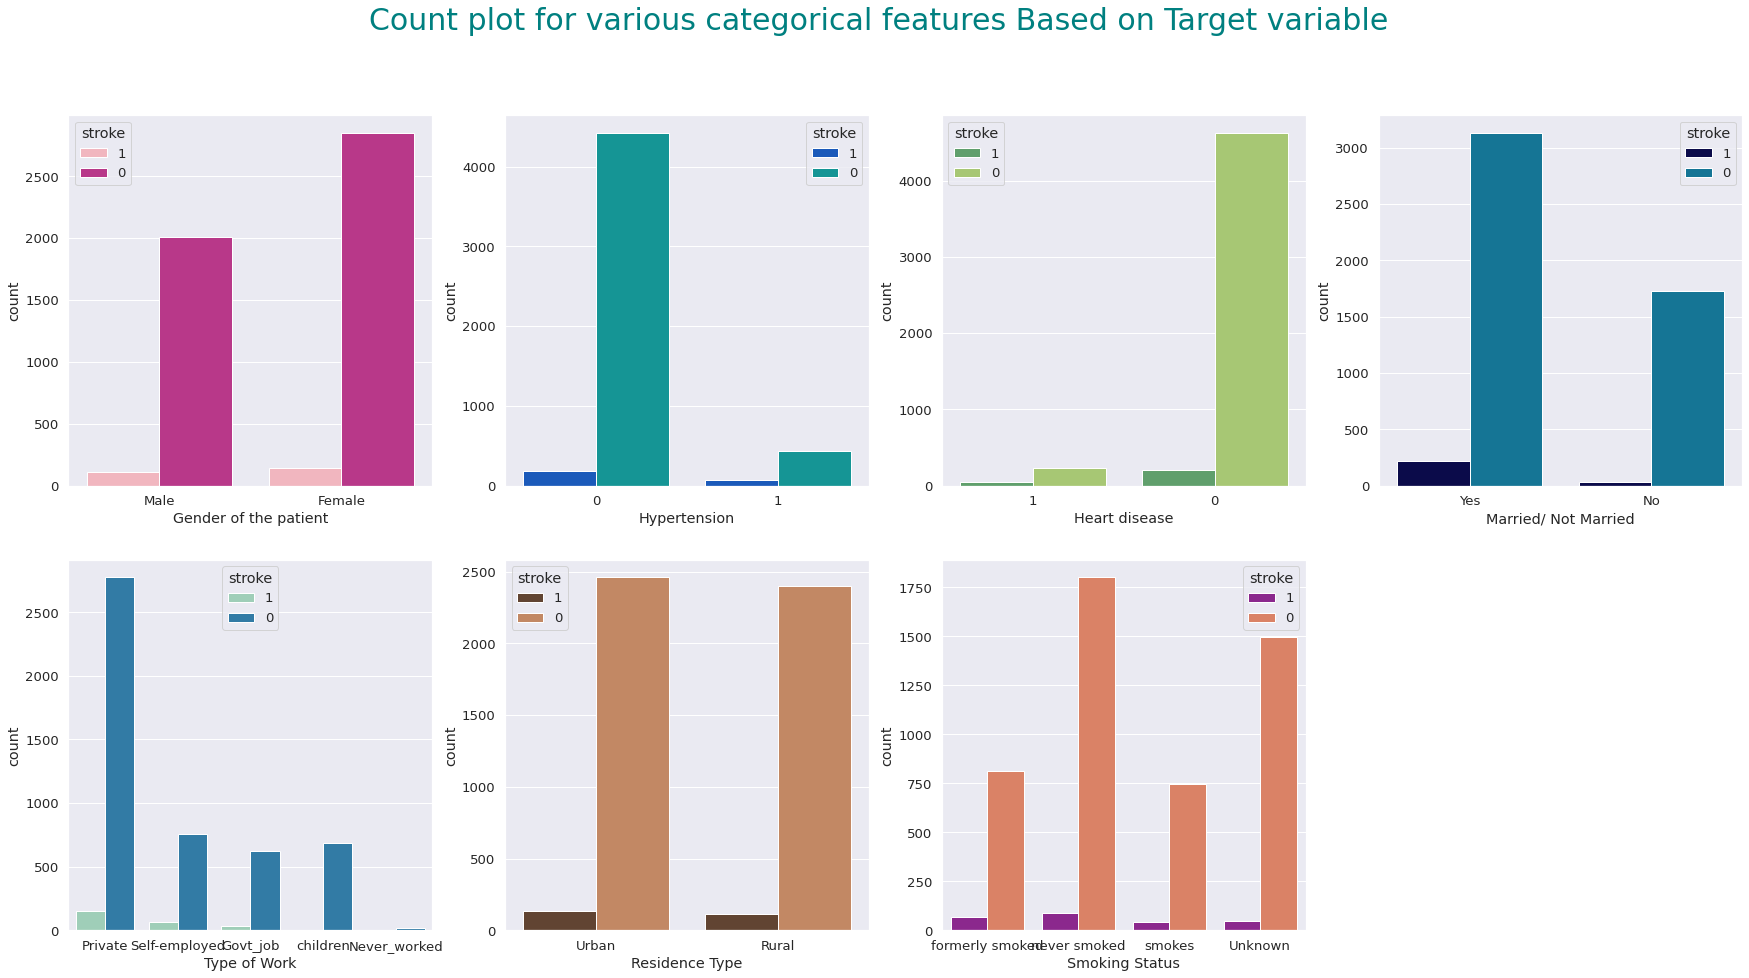

In [17]:
fig, ax = plt.subplots(2, 4, figsize = (30, 15))
ax[1, 3].axis('off')

plt.suptitle('Count plot for various categorical features Based on Target variable', fontsize = 30, color = 'teal')

ax1 = sns.countplot(x ='gender', data= data, hue= 'stroke', ax= ax[0, 0], palette= 'RdPu')
ax1.set(xlabel = 'Gender of the patient')

ax2 = sns.countplot(x ='hypertension', data= data, hue= 'stroke', ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'Hypertension')

ax3 = sns.countplot(x ='heart_disease', data= data, hue= 'stroke', ax= ax[0, 2], palette= 'summer')
ax3.set(xlabel = 'Heart disease')

ax4 = sns.countplot(x ='ever_married', data= data, hue= 'stroke', ax= ax[0, 3], palette= 'ocean')
ax4.set(xlabel = 'Married/ Not Married')

ax5 = sns.countplot(x ='work_type', data= data, hue= 'stroke', ax= ax[1, 0], palette= 'YlGnBu')
ax5.set(xlabel = 'Type of Work')

ax6 = sns.countplot(x ='Residence_type', data= data, hue= 'stroke', ax= ax[1, 1], palette= 'copper')
ax6.set(xlabel = 'Residence Type')

ax7 = sns.countplot(x ='smoking_status', data= data, hue= 'stroke', ax= ax[1, 2], palette= 'plasma')
ax7.set(xlabel = 'Smoking Status')

plt.show()

One thing I do notice is urban people have more strokes as compared to people living in rural areas

## **Filling Missing Values**

In [18]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We only have missing values in the BMI column. I will do knn imputation to fill those missing values

In [19]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [20]:
data1 = knn_impute(data, 'bmi')

In [21]:
data1.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## **Encoding**

In [22]:
data2 = pd.get_dummies(data1, drop_first= True)

In [23]:
data2.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,67.0,5.432367,3.600048,1,0,1,1,0,1,0,0,1,1,0,0,1
1,61.0,5.309307,3.535493,0,0,0,1,0,0,1,0,0,0,1,0,1
2,80.0,4.662684,3.481240,1,0,1,1,0,1,0,0,0,0,1,0,1
3,49.0,5.143008,3.538057,0,0,0,1,0,1,0,0,1,0,0,1,1
4,79.0,5.159745,3.178054,0,1,0,1,0,0,1,0,0,0,1,0,1


## **Scaling**

In [24]:
s = StandardScaler()
data2[['bmi', 'avg_glucose_level', 'age']] = s.fit_transform(data2[['bmi', 'avg_glucose_level', 'age']])

In [25]:
data3 = data2.copy()
data3.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,1.051242,2.320709,1.027679,1,0,1,1,0,1,0,0,1,1,0,0,1
1,0.785889,1.980714,0.781547,0,0,0,1,0,0,1,0,0,0,1,0,1
2,1.626174,0.194204,0.574693,1,0,1,1,0,1,0,0,0,0,1,0,1
3,0.255182,1.521257,0.791320,0,0,0,1,0,1,0,0,1,0,0,1,1
4,1.581949,1.567499,-0.581283,0,1,0,1,0,0,1,0,0,0,1,0,1


It seems like our data is ready for modelling. Lets split our dataset into train and test set

## **Data Splitting**

In [26]:
oversample = RandomOverSampler(sampling_strategy='minority')
X=data3.drop(['stroke_1'],axis=1)
y=data3['stroke_1']
X_over, y_over = oversample.fit_resample(X, y)

This oversampling step was inspired from Harshit Gupta's notebook. 
[Click Here](https://www.kaggle.com/code/casper6290/strokeprediction-99-acc) to check out the notebook

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size= 0.2, random_state= 42)

In [28]:
print(y_train.value_counts())
print(y_test.value_counts())

1    3892
0    3884
Name: stroke_1, dtype: int64
0    976
1    968
Name: stroke_1, dtype: int64


## **KNN (`97.5% Accuracy`)**

Accuracy: 0.9768518518518519
ROC AUC Score: 0.9769467213114754


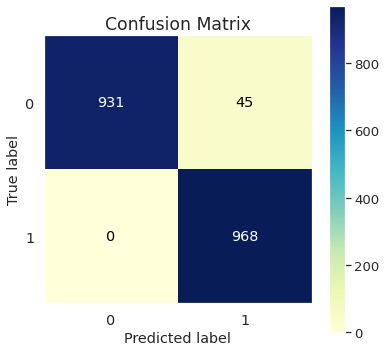

In [29]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_knn, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_knn))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_knn))

We have 0 False Negatives. It means we were able to predict all patients who had a stroke

## **SVM (`100% Accuracy`)**

Accuracy: 1.0
ROC AUC Score: 1.0


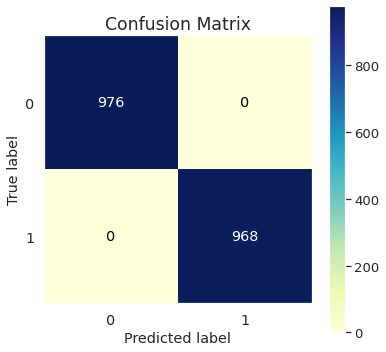

In [30]:
parameters = {
    'C':[0.001, 0.01,0.1,1,10, 100, 1000], 
    'gamma':[0.001, 0.01,0.1,1,100, 1000]
}

svm = RandomizedSearchCV(SVC(probability= True), parameters, cv=5)
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_test)
y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_svm, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_svm))

## **Random Forest (`ROC AUC Score = 1`)**

Accuracy: 0.9922839506172839
ROC AUC Score: 1.0


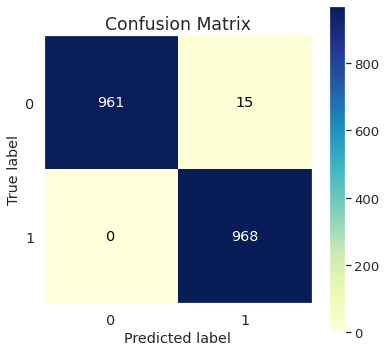

In [31]:
rf = RandomForestClassifier(n_estimators= 100)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_rf))

## **Catboost (`ROC AUC Score = 0.99`)**

Accuracy: 0.9670781893004116
ROC AUC Score: 0.9973083338978458


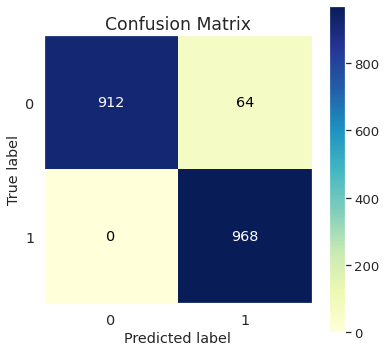

In [32]:
cb = CatBoostClassifier(verbose= 0)
cb.fit(X_train,y_train)
y_pred_cb = cb.predict(X_test)
y_pred_prob_cb = cb.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_cb, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_cb))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_cb))

## **XGBoost (`ROC AUC Score = 0.99`)**

Accuracy: 0.9789094650205762
ROC AUC Score: 0.9986811577022084


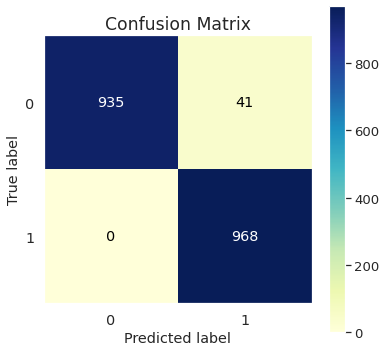

In [33]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_xgb))

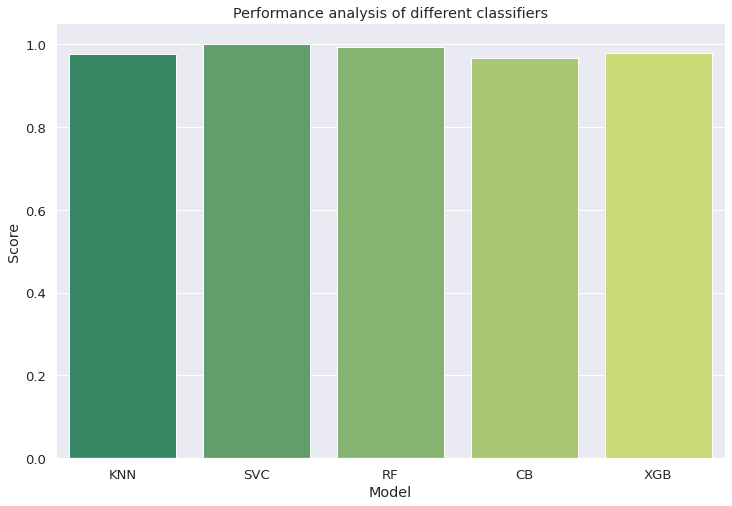

In [34]:
Performance = pd.DataFrame(
    data = {
        'Model': ['KNN', 'SVC', 'RF','CB', 'XGB'], 
        'Score': [accuracy_score(y_test, y_pred_knn),
                  accuracy_score(y_test, y_pred_svm), 
                  accuracy_score(y_test, y_pred_rf), 
                  accuracy_score(y_test, y_pred_cb), 
                  accuracy_score(y_test, y_pred_xgb)]
    }
)

plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Score", data= Performance, palette="summer")
plt.title('Performance analysis of different classifiers')
plt.show()

We can conclude that the winner is Support vector classifier, it had the highest accuracy (100%) as well as a ROC AUC score of 1. We were able to predict all the cases where the person had a stroke

Let us also plot the ROC curve before we end the notebook

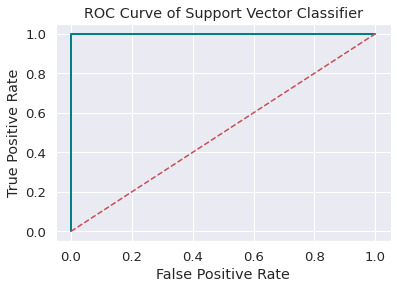

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svm)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve of Support Vector Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

Do `upvote` the notebook if you found it helpful